In [1]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [2]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [3]:
import importlib

In [4]:
import normal
import probit_network
import random_matrix
import unscented

importlib.reload(normal)
importlib.reload(unscented)

importlib.reload(random_matrix)
importlib.reload(probit_network)

from normal import Normal
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

In [5]:
key = jax.random.PRNGKey(123)

# single layer

In [6]:
f = ProbitLinear(
    3,
    1,
    key,
    A=RandomOrthogonalProjection(4.0),
    b=RandomOrthogonalProjection(0.0),
    C=RandomOrthogonalProjection(1.0),
    d=RandomOrthogonalProjection(1.0),
)
network = ProbitLinearNetwork(f)

In [7]:
dist = Normal(μ=jnp.ones(f.in_size), Σ=jnp.eye(f.in_size))

In [8]:
analytic_output = f(dist, method="analytic")
linear_output = f(dist, method="linear")
unscented_output = f(dist, method="unscented")
mc_output = f._mc_mean_cov(dist, key, 1_000_000)

In [9]:
print("linear mean", linear_output.μ)
print("unscented mean", unscented_output.μ)
print("analytic mean", analytic_output.μ)
print("monte carlo mean", mc_output.μ)

linear mean [0.9472811]
unscented mean [-1.85880441]
analytic mean [0.35838089]
monte carlo mean [0.35777946]


In [10]:
print("linear covariance", linear_output.Σ)
print("unscented covariance", unscented_output.Σ)
print("analytic covariance", analytic_output.Σ)
print("monte carlo covariance", mc_output.Σ)

linear covariance [[1.89707227]]
unscented covariance [[17.64721902]]
analytic covariance [[1.82144508]]
monte carlo covariance [[1.82030324]]


# Small-variance test

In [11]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 1
output_size = 1
hidden_size = 10
network = ProbitLinearNetwork(
    ProbitLinear(
        input_size,
        output_size,
        key1,
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
dist = Normal(μ=jnp.zeros(input_size), Σ=jnp.eye(input_size) * 1e-4)

In [12]:
mc_output = network[0]._mc_mean_cov(dist, key=jax.random.PRNGKey(1), rep=1_000_000)
mc_output.μ, mc_output.Σ

(Array([0.68265668], dtype=float64), Array([[2.34858974e-05]], dtype=float64))

In [13]:
analytic_output = network(dist, method="analytic")
analytic_output.μ, analytic_output.Σ

(Array([0.6826653], dtype=float64), Array([[2.34211033e-05]], dtype=float64))

In [14]:
linear_output = network(dist, method="linear")
linear_output.μ, linear_output.Σ

(Array([0.68268949], dtype=float64), Array([[2.34199326e-05]], dtype=float64))

In [15]:
unscented_output = network(dist, method="unscented")
unscented_output.μ, unscented_output.Σ

(Array([0.68242332], dtype=float64), Array([[0.00025776]], dtype=float64))

# Deep MLP

In [16]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 2
output_size = 1
hidden_size = 70
network = ProbitLinearNetwork(
    ProbitLinear(
        input_size,
        hidden_size,
        key1,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key2,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key3,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        output_size,
        key4,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
)

In [17]:
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size)

In [18]:
def plot_mc(ax, μ, Σ):
    dist = Normal(μ, Σ)
    unscented_output = network(dist, method="unscented")
    linear_output = network(dist, method="linear")
    analytic_output = network(dist, method="analytic")

    input_samples = dist.qmc(num_samples=2**10)
    output_samples = jax.vmap(network)(input_samples)
    y_mesh = np.linspace(np.min(output_samples), np.max(output_samples), 2000)

    ax.plot(
        y_mesh,
        scipy.stats.gaussian_kde(output_samples.reshape(-1))(y_mesh),
        label="empirical KDE",
    )
    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=output_samples.mean(), scale=output_samples.std()
        ),
        label="pseudo-true Gaussian fit",
    )

    ax.plot(
        y_mesh,
        unscented_output.pdf(y_mesh),
        label="unscented approximation",
    )

    ax.plot(
        y_mesh,
        linear_output.pdf(y_mesh),
        label="linear approximation",
        linestyle="--",
    )

    ax.plot(
        y_mesh,
        analytic_output.pdf(y_mesh),
        label="my approximation",
        linestyle="--",
    )
    ax.legend()

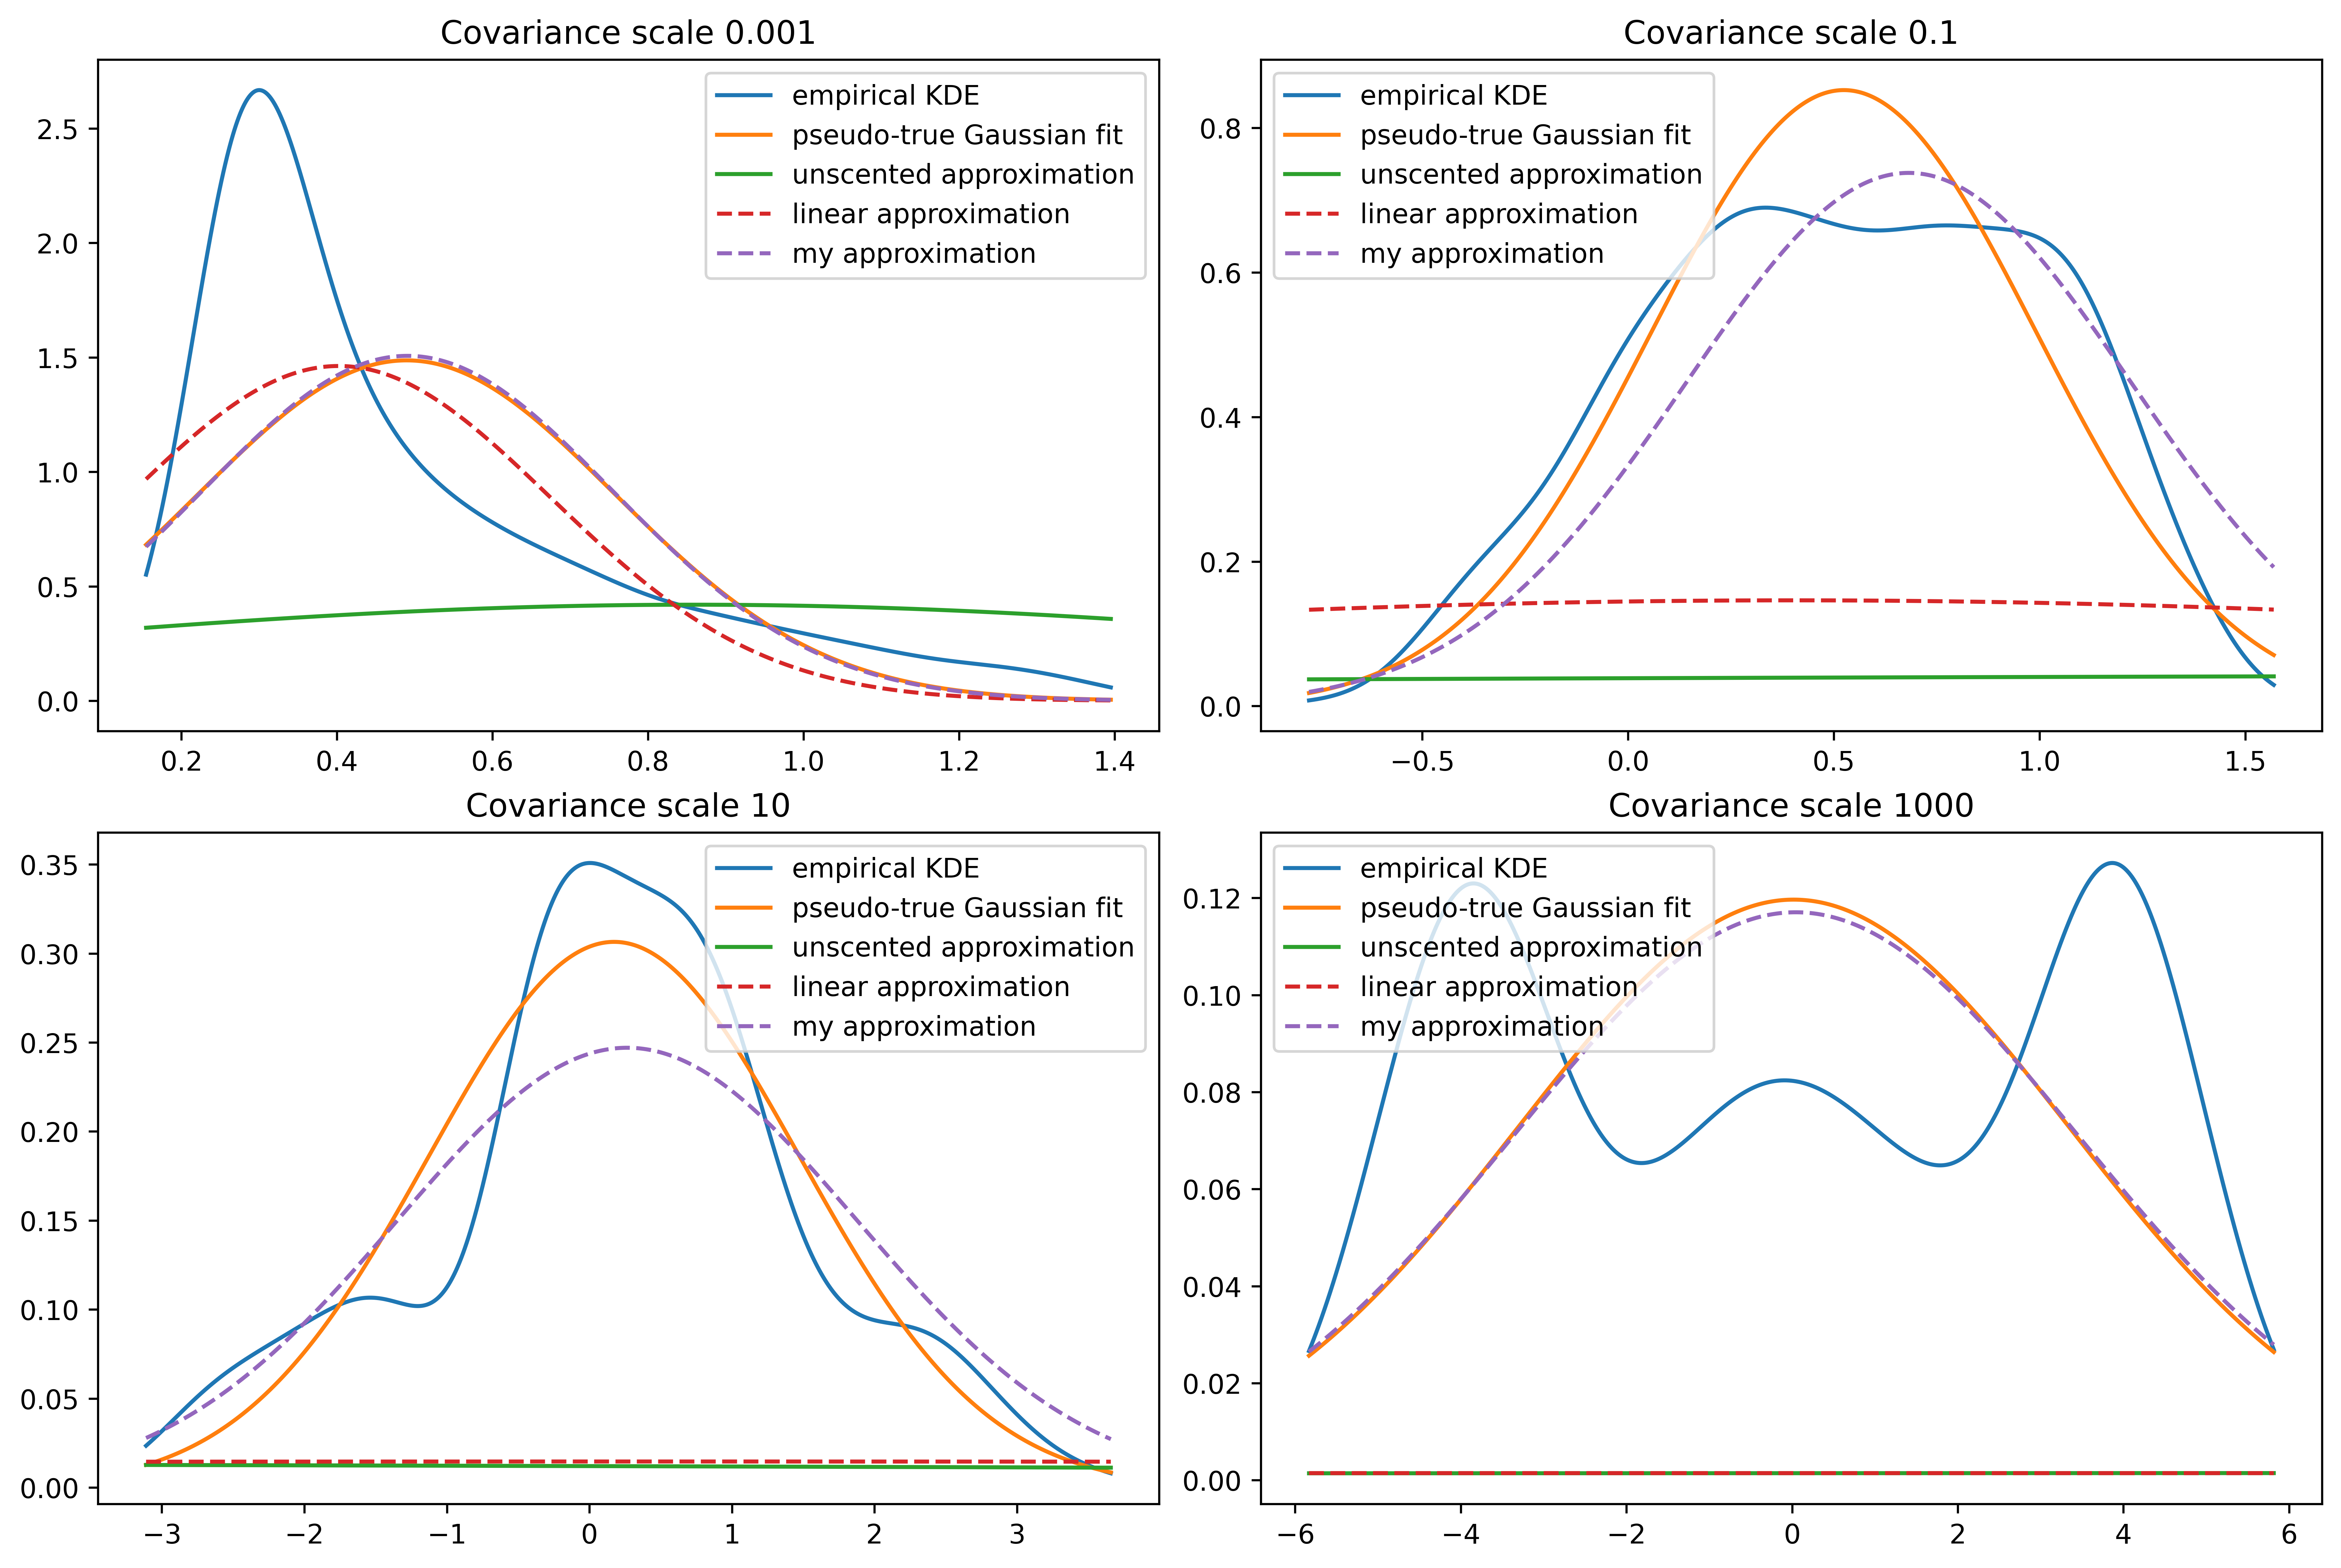

In [19]:
fig = Figure(figsize=(12, 8), dpi=600, constrained_layout=1)
ax = fig.add_subplot(221)
ax.set_title("Covariance scale 0.001")
plot_mc(ax, μ, Σ * 1e-3)
ax = fig.add_subplot(222)
ax.set_title("Covariance scale 0.1")
plot_mc(ax, μ, Σ * 1e-1)
ax = fig.add_subplot(223)
ax.set_title("Covariance scale 10")
plot_mc(ax, μ, Σ * 1e1)
ax = fig.add_subplot(224)
ax.set_title("Covariance scale 1000")
plot_mc(ax, μ, Σ * 1e3)

fig